In [7]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# Start Spark session
spark = SparkSession.builder \
    .appName("CSV Import Example") \
    .getOrCreate()

# Load first CSV
postcodes_df = spark.read.csv("../data/income/2024 Locality to 2021 SA2 Coding Index.csv", header=True, inferSchema=True)

# Load second CSV
income_df = spark.read.csv("../data/income/sa2_income.csv", header=True, inferSchema=True)

In [ ]:
# Rename columns in df2 for easier handling
income_clean = (
    income_df
    .withColumnRenamed("Statistical Areas Level 2 2021 code", "SA2_CODE_2021")
    .withColumnRenamed("Statistical Areas Level 2 2021 name", "SA2_NAME_2021")
)

# Make sure join keys are the same type
postcodes_df = postcodes_df.withColumn("SA2_CODE_2021", F.col("SA2_CODE_2021").cast("string"))

income_clean = income_clean.withColumn("SA2_CODE_2021", F.col("SA2_CODE_2021").cast("string"))

income_clean = income_clean.filter(F.col("`Personal income: Median total income (excl. Government pensions and allowances) ($) (Data year: 2020)`") != 0)


# Perform join on SA2 code
merged_df = postcodes_df.join(income_clean, on="SA2_CODE_2021", how="left")

merged_df = merged_df.drop(income_clean.SA2_NAME_2021)  # drop df2’s version


result_df = (
    merged_df
    .groupBy(F.col("POSTCODE").alias("postcode"))
    .agg(
        F.avg(
            F.col("`Personal income: Median total income (excl. Government pensions and allowances) ($) (Data year: 2020)`")
        ).alias("median_total_income_2020")
    )
)

result_df.show(100, truncate=False)

result_df.printSchema()

result_df.write.csv("../data/curated/merged_postcode_income.csv", header=True, mode="overwrite")


+--------+------------------------+
|postcode|median_total_income_2020|
+--------+------------------------+
|2904    |68383.0                 |
|2136    |54202.0                 |
|2294    |57839.0                 |
|2069    |65475.0                 |
|2162    |41993.0                 |
|2088    |NULL                    |
|829     |69030.5                 |
|4821    |54343.0                 |
|4032    |53958.0                 |
|7252    |46179.142857142855      |
|3414    |49436.0                 |
|3959    |39276.0                 |
|6240    |41881.0                 |
|6613    |52638.0                 |
|2464    |38171.0                 |
|2756    |52936.878787878784      |
|2110    |76214.0                 |
|800     |55435.0                 |
|853     |64192.0                 |
|5023    |51982.0                 |
|5523    |44641.392857142855      |
|5067    |57750.166666666664      |
|3441    |61638.0                 |
|3517    |41140.0                 |
|3858    |31523.75          

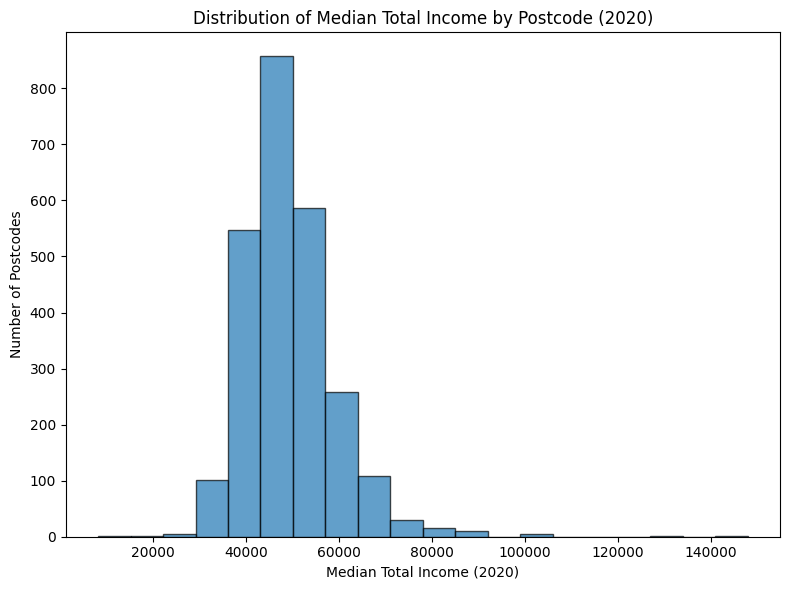

In [14]:

pdf = result_df.toPandas()
# Drop missing values (important to avoid errors)
pdf = pdf.dropna(subset=["median_total_income_2020"])

# Histogram
plt.figure(figsize=(8, 6))
plt.hist(pdf["median_total_income_2020"], bins=20, edgecolor="black", alpha=0.7)

plt.xlabel("Median Total Income (2020)")
plt.ylabel("Number of Postcodes")
plt.title("Distribution of Median Total Income by Postcode (2020)")
plt.tight_layout()
plt.show()

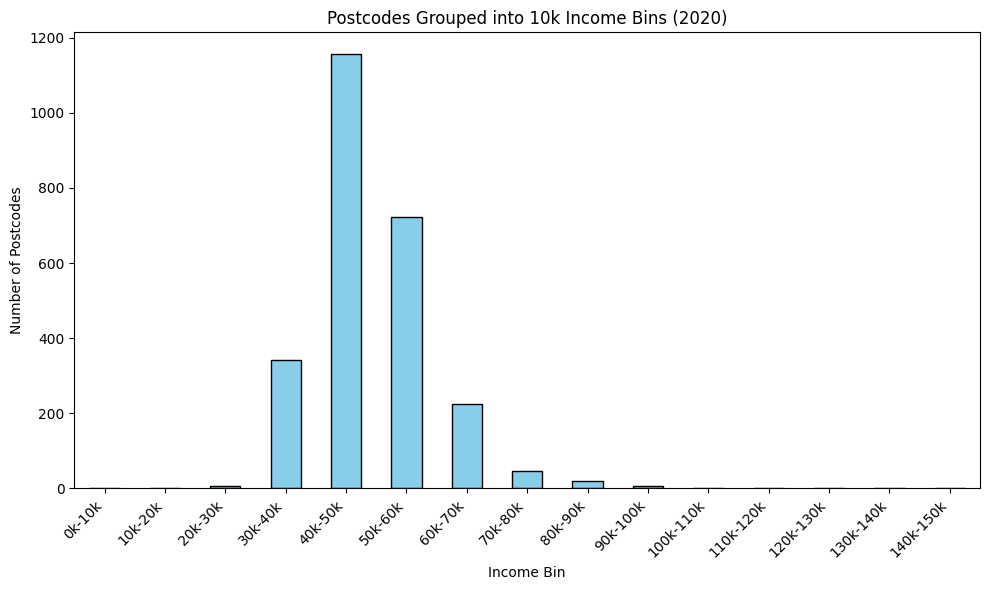

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Drop missing values
pdf = pdf.dropna(subset=["median_total_income_2020"])

# Define bin edges in 10k intervals
min_val = pdf["median_total_income_2020"].min()
max_val = pdf["median_total_income_2020"].max()

# Start from the nearest 10k below min, go to nearest 10k above max
bins = np.arange((min_val // 10000) * 10000, ((max_val // 10000) + 1) * 10000 + 1, 10000)

# Create labels like "30k-40k", "40k-50k", etc.
labels = [f"{int(bins[i]/1000)}k-{int(bins[i+1]/1000)}k" for i in range(len(bins)-1)]

# Categorize incomes into bins
pdf["income_bin"] = pd.cut(pdf["median_total_income_2020"], bins=bins, labels=labels, right=False)

# Count how many postcodes fall into each bin
bin_counts = pdf["income_bin"].value_counts().sort_index()

# Bar chart
plt.figure(figsize=(10, 6))
bin_counts.plot(kind="bar", color="skyblue", edgecolor="black")

plt.xlabel("Income Bin")
plt.ylabel("Number of Postcodes")
plt.title("Postcodes Grouped into 10k Income Bins (2020)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [5]:
missing_count = merged_df.filter(F.col("`Personal income: Median total income (excl. Government pensions and allowances) ($) (Data year: 2020)`").isNull()).count()
print(missing_count)

1699


In [26]:
consumer_df = spark.read.csv("../data/tables/merchant_data/tbl_consumer.csv", header=True, inferSchema=True)